# Importamos librerias 📚

In [2]:
# Bibliotecas generales
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

# Modulos espcificos de Sklearn

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA


from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Creamos DataFrame ✅

In [4]:
dt_heart  =pd.read_csv("../data/heart.csv")
dt_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# Creamos Variables de Train y Test

In [5]:
dt_features = dt_heart.drop(["target"], axis=1)
dt_target = dt_heart["target"]
#Normalizamos los datos (escalarlos)
dt_features = StandardScaler().fit_transform(dt_features)
# Realizamos la separación de datos entre entrenamiento y test 

X_train, X_test, y_train, y_test = train_test_split(dt_features,dt_target,test_size=.3, random_state=42)



In [6]:
print("Tamaño de X_train", X_train.shape)
print("Tamaño de y_train", y_train.shape)


Tamaño de X_train (717, 13)
Tamaño de y_train (717,)


# Aplicando PCA

In [35]:
# El numero de componentes no es necesario, si no se pone el número seria
# n_components = min(n_muestras, n_features)
components = 3
pca = PCA(n_components=components)

pca.fit(X_train)

# Comparación con incremental PCA IPCA
# batch_size -> cantidad de bloques que manda a entrenamiento (consumindo así menos GPU)
ipca = IncrementalPCA(n_components=components, batch_size=10)
ipca.fit(X_train)



IncrementalPCA(batch_size=10, n_components=3)

## Medir la varianza

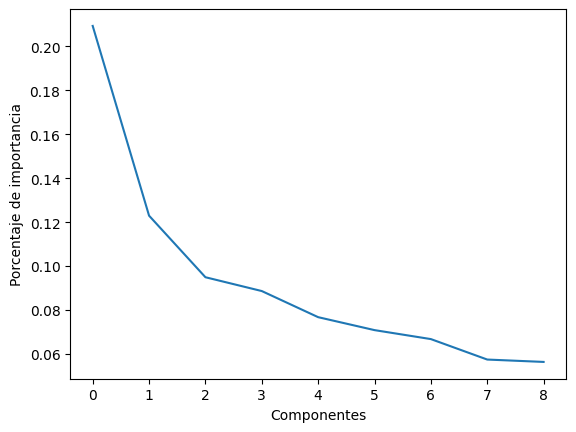

In [29]:
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)

plt.ylabel("Porcentaje de importancia")
plt.xlabel("Componentes")
plt.show()

Podemos observar que la grafica consta de tres puntos en ($x,y$) puntos que hacen referencia a *n_components* que seleccionamos para el PCA
* El primer componenten nos aporta sobre el 20% de información
* La segundo nos aporta cerca al 13%
* y la última nos aporta menos del 10%

Las dos primeras componentes son las que mas información aportan a nuestro modelo 

## Pruebas para escoger el mejor n_components

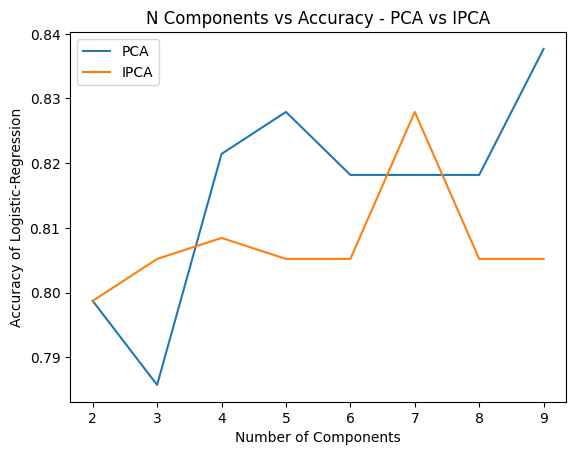

In [50]:
# Configuracion de la regresión logística
logistic = LogisticRegression(solver='lbfgs')

pca_data = {'accuracy': [], # Exactitud
            'n_components': []}
ipca_data = {'accuracy': [],
            'n_components': []}
# PCA
for n in range(2, 10):
    pca = PCA(n_components=n)
    pca.fit(X_train)
    df_train = pca.transform(X_train)
    df_test = pca.transform(X_test)
    logistic.fit(df_train, y_train)
    acccuracy = logistic.score(df_test, y_test)
    
    pca_data['accuracy'].append(acccuracy)
    pca_data['n_components'].append(n)

# IPC
for n in range(2, 10):
    ipca = IncrementalPCA(n_components=n, batch_size=10)
    ipca.fit(X_train)
    df_train = ipca.transform(X_train)
    df_test = ipca.transform(X_test)
    logistic.fit(df_train, y_train)
    acccuracy = logistic.score(df_test, y_test)
    
    ipca_data['accuracy'].append(acccuracy)
    ipca_data['n_components'].append(n)


plt.plot(pca_data['n_components'], pca_data['accuracy'], label='PCA')
plt.plot(ipca_data['n_components'], ipca_data['accuracy'], label='IPCA')
plt.title('N Components vs Accuracy - PCA vs IPCA')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy of Logistic-Regression')
plt.legend()
plt.show()

# Regresión logistica

In [49]:
logistic = LogisticRegression(solver="lbfgs")

# Mandar nuestro entrenamiento a prueba con PCA e IPCA

dt_train = pca.transform(X_train)
dt_test = pca.transform(X_test)
logistic.fit(dt_train, y_train)

print("Socre PCA: %.2f%% con n_components: %d" % ((logistic.score(dt_test,y_test)*100), components))


# de nuevo con IPCA para comparar score

dt_train = ipca.transform(X_train)
dt_test = ipca.transform(X_test)
logistic.fit(dt_train, y_train)

print("Socre IPCA: %.2f%% con n_components: %d" % ((logistic.score(dt_test,y_test)*100), components))



Socre PCA: 78.57% con n_components: 3
Socre IPCA: 80.52% con n_components: 3
